In [251]:
import numpy as np
import pandas as pd
import math
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

In [200]:
# importing cost matrix created using k-strip algorithm 
mat2 = numpy.load("protein_big .dat")

In [201]:
mat2

array([[   0.,  132.,  116., ...,  122.,  227.,  110.],
       [ 132.,    0.,  123., ...,  131.,  233.,  132.],
       [ 116.,  123.,    0., ...,  111.,  241.,  116.],
       ..., 
       [ 122.,  131.,  111., ...,    0.,  233.,  121.],
       [ 227.,  233.,  241., ...,  233.,    0.,  227.],
       [ 110.,  132.,  116., ...,  121.,  227.,    0.]])

In [202]:
# importing pickled dataframe used to derive cost matrix
protein = pd.read_pickle("protein_4000")

In [203]:
protein.head()

,Protein,Unknown,Label,Protein string
0,1GME_A,151,1,MSIVRRSNVFDPFADLWADPFDTFRSIVPAISGGGSETAAFANARM...
2,1TVG_A,153,16,MGHHHHHHSHMRKIDLCLSSEGSEVILATSSDEKHPPENIIDGNPE...
3,2N3JB,98,99,MQLSSGVSEIRHTADRWRVSLDVNHFAPDELTVKTKDGVVEITGKH...
5,3L1E_A,106,99,GSGISEVRSDRDKFVIFLDVKHFSPEDLTVKVQEDFVEIHGKHNER...
6,4JUSA,104,99,APSVALPVAQVPTDPGHFSVLLDVKHFSPEEIAVKVVGEHVEVHAR...


### Creating the combined dataframe

In [204]:
# creating a list of column names : Pr_1 until Pr_4000
pr_rowname = []
for i in range(1,4001):
    pr_rowname.append("Pr_"+str(i))
    

In [205]:
# creating dataframe from cost matrix
protein_cmb = pd.DataFrame(data=mat2[:,:],    # values
                           index=pr_rowname,  # 1s t column as index
                           columns=pr_rowname) 

In [208]:
# combining the labels to the dataframe 'protein_cmb"
se = pd.Series(protein['Label'].tolist())
protein_cmb['Label'] = se.values
protein_cmb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, Pr_1 to Pr_4000
Columns: 4001 entries, Pr_1 to Label
dtypes: float64(4000), int64(1)
memory usage: 122.1+ MB


In [210]:
# preprocessing - removing any NaNs or infinity values
protein_ppr = protein_cmb .replace([np.inf,np.nan],0)
protein_ppr.describe()

,Pr_1,Pr_2,Pr_3,Pr_4,Pr_5,Pr_6,Pr_7,Pr_8,Pr_9,Pr_10,...,Pr_3992,Pr_3993,Pr_3994,Pr_3995,Pr_3996,Pr_3997,Pr_3998,Pr_3999,Pr_4000,Label
count,4000.00000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,129.98400,144.258500,131.591250,133.76550,133.202750,133.518250,159.813250,195.331750,165.369250,158.536750,...,134.350750,225.552750,133.140250,232.444500,134.460750,134.138000,133.256750,228.764250,133.945000,38.089000
std,40.67207,32.193412,39.510675,38.49626,38.702527,38.398578,46.502726,15.867944,24.436503,26.084512,...,38.462847,16.409419,40.786952,20.466733,38.348945,38.445149,39.778115,16.816268,36.289526,41.452221
min,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,112.00000,129.000000,112.000000,113.00000,113.000000,114.000000,135.000000,190.000000,157.000000,149.000000,...,118.000000,223.000000,113.000000,231.000000,119.000000,118.000000,118.000000,226.000000,114.000000,10.000000
50%,124.00000,133.000000,118.000000,121.00000,121.000000,121.000000,146.000000,192.000000,161.000000,153.000000,...,124.000000,226.000000,123.000000,233.000000,125.000000,124.000000,125.000000,229.000000,122.000000,12.000000
75%,138.00000,145.000000,136.000000,141.00000,136.000000,137.000000,170.000000,196.000000,166.000000,158.000000,...,142.000000,229.000000,142.000000,236.000000,143.000000,141.000000,141.000000,232.000000,140.000000,99.000000
max,409.00000,410.000000,428.000000,427.00000,428.000000,427.000000,490.000000,390.000000,399.000000,400.000000,...,417.000000,394.000000,429.000000,390.000000,417.000000,415.000000,415.000000,396.000000,419.000000,99.000000


### Training the Random Forest model

In [225]:
# splitting dataset into train and test sets
X = protein_ppr.drop('Label',axis=1)
y = protein_ppr['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [226]:
# creating an instance of the random forest classifier 
rfc_base = RandomForestClassifier()

In [227]:
"""
To avoid overfitting and arrive at optimal tuning for the hyper parmeters the gridsearchCV
function is used.
param_grid   : Input for parameter values to run the classifer with 
cv           : Number of splits for conducting a k-fold cross validation 
n_estimators : Number of tress in the forest
max_features : The number of features to consider when looking for the best split
"""

param_grid = { 
    'n_estimators': [200, 400,600,800,1000],
    'max_features': ['auto', 'sqrt', 'log2']
}

cv = KFold(n_splits = 10, shuffle= True, random_state = 0)
rfc = GridSearchCV(rfc_base, param_grid = param_grid ,cv=cv)

# Fitting the random forest instance call with the training set
rfc.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200, 400, 600, 800, 1000], 'max_features': ['auto', 'sqrt', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [230]:
# Best estimator
rfc.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [231]:
# Best score achieved during cross-validation
rfc.best_score_

0.86142857142857143

In [232]:
# Best values for hyperparameters
rfc.best_params_

{'max_features': 'auto', 'n_estimators': 1000}

In [229]:
# pickling the randomforest instance for future use
filename = 'rf_4000_py2.sav'
pickle.dump(rfc, open(filename, 'wb'),protocol=2)

In [233]:
predictions = rfc.predict(X_test)

In [235]:
print(classification_report(y_test,predictions))
classification_report()

             precision    recall  f1-score   support

          1       0.97      0.93      0.95        83
          2       1.00      1.00      1.00        21
          3       0.86      1.00      0.92         6
          4       0.83      0.71      0.77         7
          5       1.00      1.00      1.00         8
          6       0.92      0.92      0.92        24
          7       0.95      0.83      0.89        24
          8       0.90      1.00      0.95         9
          9       1.00      0.97      0.98        65
         10       0.95      0.99      0.97       158
         11       0.85      0.65      0.73       188
         12       0.92      0.89      0.90       112
         13       1.00      0.75      0.86        12
         14       1.00      0.81      0.90        16
         15       1.00      1.00      1.00         4
         16       1.00      1.00      1.00        14
         17       1.00      1.00      1.00        21
         18       1.00      0.50      0.67   

### Accuracy Historgram

In [ ]:
plt.figure(figsize=(10,6))
loans[loans['credit.policy']==1]['fico'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Credit.Policy=1')
loans[loans['credit.policy']==0]['fico'].hist(alpha=0.5,color='red',
                                              bins=30,label='Credit.Policy=0')
                                             
plt.legend()
plt.xlabel('FICO')

In [254]:
dat_results = pd.DataFrame({"Predicted_Val":predictions, "Actual_Val":y_test})
dat_results = dat_results.replace(99,22)

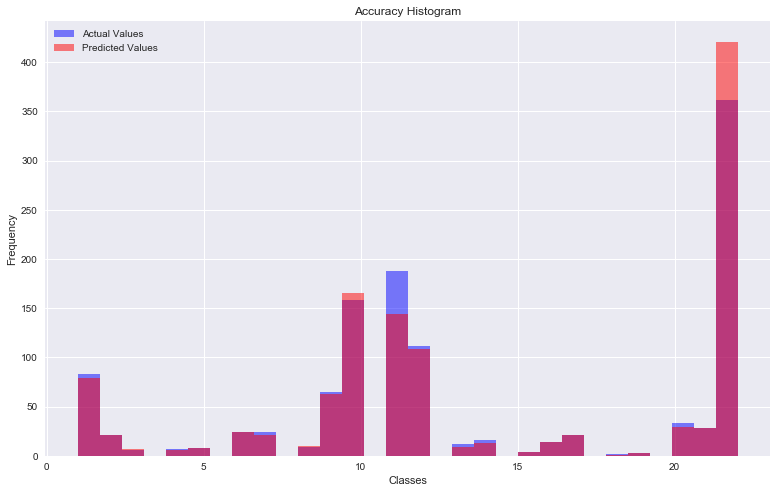

In [269]:
plt.figure(figsize=(13,8))
dat_results['Actual_Val'].hist(alpha=0.5,color='blue',
                                              bins=30,label='Actual Values')
dat_results['Predicted_Val'].hist(alpha=0.5,color='red',
                                              bins=30,label='Predicted Values')
plt.legend()
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Accuracy Histogram")